### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
import itertools
import random

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [2]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')
# Log Transform Sales
#train['logsales'] = np.log(train.sales)
display(train.head())

random.seed(1970)
stores = random.sample(range(11), 2)    # Choosing 2 of the 10 stores randonly
items = random.sample(range(51), 5)     # Choosing 5 of the 50 items randomly

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### Commentary
We build a new timeseries that sums the sales for all stores and all items. 

We fit models to this timeseries and also test the efficacy of those models to predict both for the new timeseries and a store-product pair timeseries.

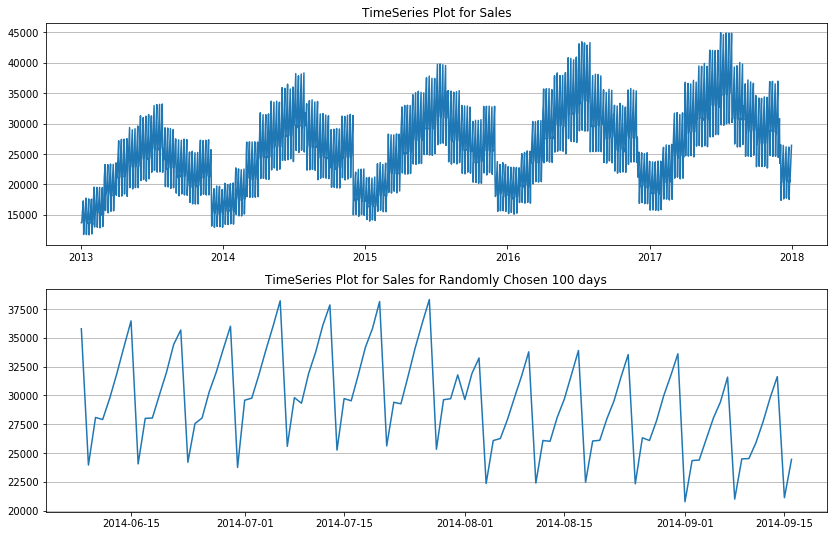

ADF test statistic: -3.0217
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.9638
   5%        -3.4129
  10%        -3.1285

p-value: 1.2612e-01


In [3]:
sales_all = train.groupby('date')['sales'].sum()
sales_all.index = pd.DatetimeIndex(sales_all.index.values, freq = 'D')

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(sales_all.index, sales_all)
ax1.set_title('TimeSeries Plot for Sales')
ax1.grid(axis = 'y')

ax2.plot(sales_all.index[523:624], sales_all[523:624])
ax2.set_title('TimeSeries Plot for Sales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

result = adfuller(sales_all, regression = 'ct')
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

#### Observations
The first graph shows two trends in the data - 
    a month-on-month trend in a year - sales go up for first half of the year and come down in the second half and this trend repeats year after year, and 
    an upward year-on-year trend.
    
The second graph shows that there is trend within week - for the week starting Monday, daily sales go up getting to their highest value on Sunday.

Moreover, the Augmented Dickey-Fuller (ADF) test confirms that the series is not stationary.
    
To apply ARIMA/SARIMA models we need to make the series stationary. To that end we difference the series and then visually and formulaicly test if the new series is stationary.

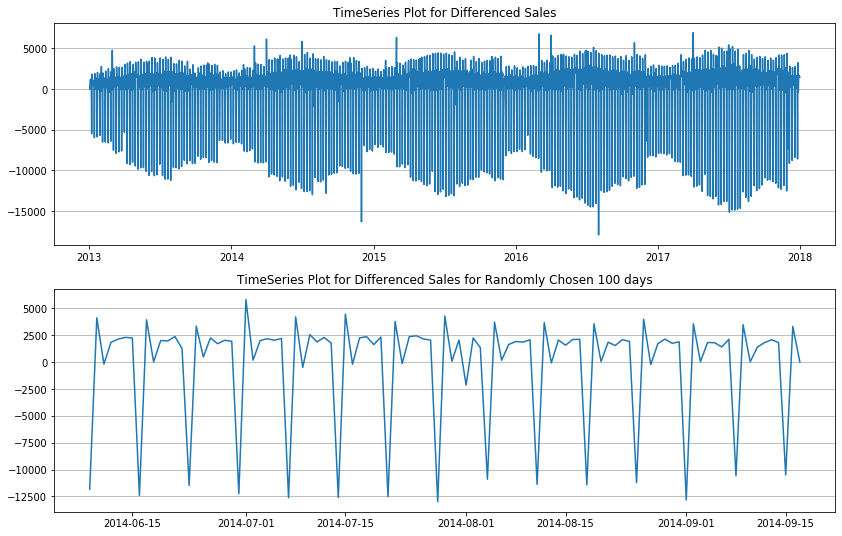

In [4]:
sales_all_1 = sales_all.diff().dropna()

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(sales_all_1.index, sales_all_1)
ax1.set_title('TimeSeries Plot for Differenced Sales')
ax1.grid(axis = 'y')

ax2.plot(sales_all_1.index[523:624], sales_all_1[523:624])
ax2.set_title('TimeSeries Plot for Differenced Sales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

In [5]:
result = adfuller(sales_all_1)                # Notice that regression = 'none' as there is no visible trend 
                                              # to the differenced series.
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -8.9190
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.4340
   5%        -2.8631
  10%        -2.5676

p-value: 1.0534e-14


#### Observations
We can confirm visually that the differenced series is stationary in that it seems to have a constant mean and constant variance. Moreover, the ADF test confirms this observation.

We use this transformed series to build the ARIMA/SARIMA models.

We first investigate the existence of autocorrelation in the series using the Ljung-Box test and then investigate the ACF and PACF plots for the series.

In [6]:
result = acorr_ljungbox(sales_all_1, lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1      8.698029e-46
2      1.472491e-44
3      1.847159e-52
4      2.766107e-60
5      2.359325e-59
6     1.929484e-101
7      0.000000e+00
8      0.000000e+00
9      0.000000e+00
10     0.000000e+00
Name: lb_pvalue, dtype: float64


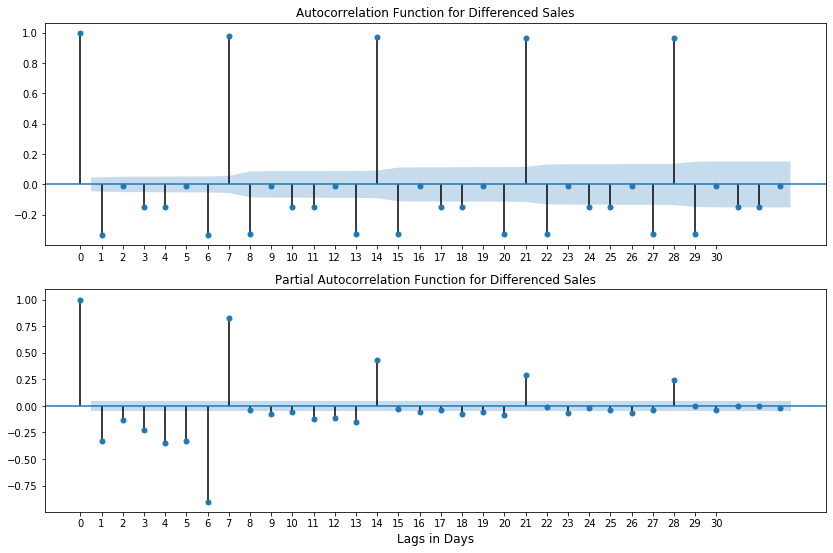

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))

tsaplots.plot_acf(sales_all_1, ax = ax1, alpha = 0.05,
                  title = 'Autocorrelation Function for Differenced Sales')
tsaplots.plot_pacf(sales_all_1, ax = ax2, alpha = 0.05,
                   title = 'Partial Autocorrelation Function for Differenced Sales')

ax1.set_xticks(np.arange(0, 31, 1))
ax2.set_xticks(np.arange(0, 31, 1))
ax2.set_xlabel('Lags in Days', fontsize = '12')

plt.show()

#### Observations

Since the series was differenced before plotting the ACF and PACF; d = 1 (and D = 0).

Regular peaks in both ACF and PACF at lags 7, 14, 21, 28; s = 7

Near term peaks in ACF at lags 1, 3, 4 and 6, p = 1, (1, 3), (1, 3 ,4), (1, 3, 4, 6) and P = 0, 1

Near term peaks in PACF at lags 1 thru 6, q = 1, 2, 3, 4, 5, 6 and Q = 0, 1

Grid Search optimal values for the SARIMA parameters using AIC as the criterion for choice. We split the sales_all_1 dataset into train and val subsets. The train subset consists of the first 90% elements of the sales_all_1 dataset.


In [8]:
n_train = np.int(0.9*len(sales_all_1))
history = sales_all_1[:n_train]

ma_order = [1, (1, 0, 1), (1, 0, 1, 1), (1, 0, 1, 1, 0, 1)]
ar_order = np.arange(1, 7)
ma_sorder = np.arange(0, 2)
ar_sorder = np.arange(0, 2)
diff = np.arange(1, 2)
diff_s = np.arange(0, 1)
span_s = np.arange(7, 8)
trend = ['n', 'c', 't', 'ct']

for p in ma_order:
    for q in ar_order:
        for P in ma_sorder:
            for Q in ar_sorder:
                for d in diff:
                    for D in diff_s:
                        for s in span_s:
                            for t in trend:
                                try:
                                    model = SARIMAX(history, order = (p, d, q), seasonal_order = (P, D, Q, s),
                                                    trend = t, enforce_stationarity = False, 
                                                    enforce_invertability = False).fit(method = 'powell', 
                                                                                       disp = False)
                                    print('SARIMA{}{} trend {} - AIC:{}'.format((p,d,q), (P,D,Q,s), t, 
                                                                               model.aic))
                                except:
                                    continue
                                
                                
                                

SARIMA(1, 1, 1)(0, 0, 0, 7) trend n - AIC:31961.72064330897
SARIMA(1, 1, 1)(0, 0, 0, 7) trend c - AIC:31963.717403469615
SARIMA(1, 1, 1)(0, 0, 0, 7) trend t - AIC:31963.7021470392
SARIMA(1, 1, 1)(0, 0, 0, 7) trend ct - AIC:31965.617170084588
SARIMA(1, 1, 1)(0, 0, 1, 7) trend n - AIC:30243.364105258115
SARIMA(1, 1, 1)(0, 0, 1, 7) trend c - AIC:30245.346782295244
SARIMA(1, 1, 1)(0, 0, 1, 7) trend t - AIC:30245.324407838227
SARIMA(1, 1, 1)(0, 0, 1, 7) trend ct - AIC:30247.266477776477
SARIMA(1, 1, 1)(1, 0, 0, 7) trend n - AIC:26952.449759634987
SARIMA(1, 1, 1)(1, 0, 0, 7) trend c - AIC:26954.43361410257
SARIMA(1, 1, 1)(1, 0, 0, 7) trend t - AIC:26954.42890025952
SARIMA(1, 1, 1)(1, 0, 0, 7) trend ct - AIC:26956.38751271915
SARIMA(1, 1, 1)(1, 0, 1, 7) trend n - AIC:26379.540437519114
SARIMA(1, 1, 1)(1, 0, 1, 7) trend c - AIC:26381.59716249661
SARIMA(1, 1, 1)(1, 0, 1, 7) trend t - AIC:26381.513383676902
SARIMA(1, 1, 1)(1, 0, 1, 7) trend ct - AIC:26396.484687006032


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(1, 1, 2)(0, 0, 0, 7) trend n - AIC:31495.36800216447
SARIMA(1, 1, 2)(0, 0, 0, 7) trend c - AIC:31498.224517429528
SARIMA(1, 1, 2)(0, 0, 0, 7) trend t - AIC:31497.34773703791
SARIMA(1, 1, 2)(0, 0, 0, 7) trend ct - AIC:31952.923129047354
SARIMA(1, 1, 2)(0, 0, 1, 7) trend n - AIC:29909.201157474294
SARIMA(1, 1, 2)(0, 0, 1, 7) trend c - AIC:29911.19848277921
SARIMA(1, 1, 2)(0, 0, 1, 7) trend t - AIC:29911.11180043462
SARIMA(1, 1, 2)(0, 0, 1, 7) trend ct - AIC:30239.00691515246
SARIMA(1, 1, 2)(1, 0, 0, 7) trend n - AIC:26956.35468853122
SARIMA(1, 1, 2)(1, 0, 0, 7) trend c - AIC:26958.356543975766
SARIMA(1, 1, 2)(1, 0, 0, 7) trend t - AIC:26958.353837038732
SARIMA(1, 1, 2)(1, 0, 0, 7) trend ct - AIC:26960.303005488746
SARIMA(1, 1, 2)(1, 0, 1, 7) trend n - AIC:26368.002868386182
SARIMA(1, 1, 2)(1, 0, 1, 7) trend c - AIC:26369.9622588286
SARIMA(1, 1, 2)(1, 0, 1, 7) trend t - AIC:26369.66943528268
SARIMA(1, 1, 2)(1, 0, 1, 7) trend ct - AIC:26371.947546565116
SARIMA(1, 1, 3)(0, 0, 0, 7) t

SARIMA((1, 0, 1), 1, 4)(0, 0, 0, 7) trend c - AIC:30708.367745237218
SARIMA((1, 0, 1), 1, 4)(0, 0, 0, 7) trend t - AIC:30721.29290062409
SARIMA((1, 0, 1), 1, 4)(0, 0, 0, 7) trend ct - AIC:30709.849976498605
SARIMA((1, 0, 1), 1, 4)(0, 0, 1, 7) trend n - AIC:29255.851603495677
SARIMA((1, 0, 1), 1, 4)(0, 0, 1, 7) trend c - AIC:29253.782160935032
SARIMA((1, 0, 1), 1, 4)(0, 0, 1, 7) trend t - AIC:29250.4682116985
SARIMA((1, 0, 1), 1, 4)(0, 0, 1, 7) trend ct - AIC:29341.011324549545
SARIMA((1, 0, 1), 1, 4)(1, 0, 0, 7) trend n - AIC:26927.17991521796
SARIMA((1, 0, 1), 1, 4)(1, 0, 0, 7) trend c - AIC:26929.306967068445
SARIMA((1, 0, 1), 1, 4)(1, 0, 0, 7) trend t - AIC:26929.390682478428
SARIMA((1, 0, 1), 1, 4)(1, 0, 0, 7) trend ct - AIC:26929.10137197191
SARIMA((1, 0, 1), 1, 4)(1, 0, 1, 7) trend n - AIC:26329.26262457293
SARIMA((1, 0, 1), 1, 4)(1, 0, 1, 7) trend c - AIC:26331.24170754689
SARIMA((1, 0, 1), 1, 4)(1, 0, 1, 7) trend t - AIC:26331.270498117345
SARIMA((1, 0, 1), 1, 4)(1, 0, 1, 7) tr

SARIMA((1, 0, 1, 1), 1, 5)(0, 0, 1, 7) trend t - AIC:28965.793253773707
SARIMA((1, 0, 1, 1), 1, 5)(0, 0, 1, 7) trend ct - AIC:29073.110464782807
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 0, 7) trend n - AIC:26717.51206215487
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 0, 7) trend c - AIC:26759.46359218707
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 0, 7) trend t - AIC:26754.79047984184
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 0, 7) trend ct - AIC:26741.303905753906
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 1, 7) trend n - AIC:26311.840869089046
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 1, 7) trend c - AIC:26313.783037036737
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 1, 7) trend t - AIC:26313.829197365234
SARIMA((1, 0, 1, 1), 1, 5)(1, 0, 1, 7) trend ct - AIC:26316.28807238776
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 0, 7) trend n - AIC:30074.65897435253
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 0, 7) trend c - AIC:30076.69942132377
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 0, 7) trend t - AIC:30076.57598351294
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 0, 7) trend ct - AIC:29641.31514623

SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 0, 7) trend t - AIC:29506.04544174416
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 0, 7) trend ct - AIC:29507.858911874093
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 1, 7) trend n - AIC:28880.257534327284
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 1, 7) trend c - AIC:28882.267336448764
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 1, 7) trend t - AIC:28883.335067125183
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(0, 0, 1, 7) trend ct - AIC:28886.090197881116
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 0, 7) trend n - AIC:26714.472522175696
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 0, 7) trend c - AIC:26685.61751956711
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 0, 7) trend t - AIC:26722.081265896908
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 0, 7) trend ct - AIC:26674.90211976092
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 1, 7) trend n - AIC:26295.460320878636
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 1, 7) trend c - AIC:26297.40906092529
SARIMA((1, 0, 1, 1, 0, 1), 1, 6)(1, 0, 1, 7) trend t - AIC:26297.

Best Model SARIMA(1, 1, 6)(1, 0, 1, 7) trend n - AIC:26291.238879347628

               ---------------*****************---------------------***********************---------------

In [34]:
for i in [1, (2, 3)]:
    print(i)

1
(2, 3)


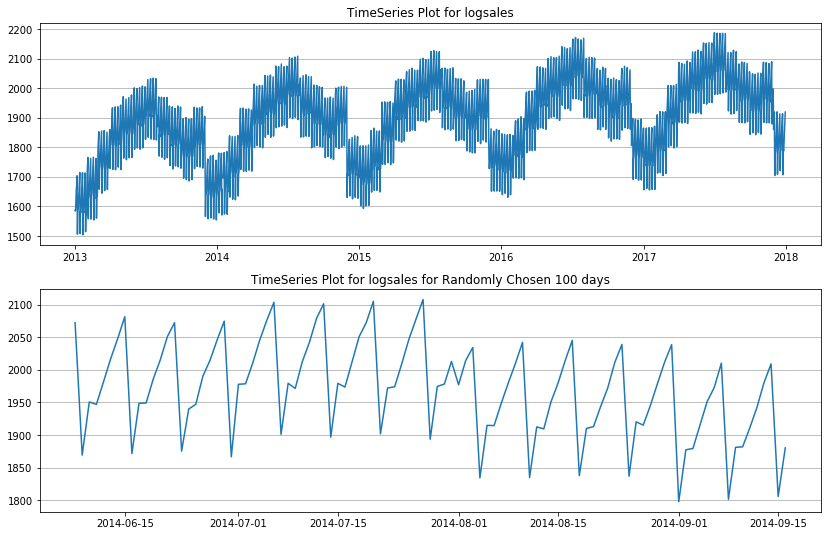

ADF test statistic: -3.0217
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.9638
   5%        -3.4129
  10%        -3.1285

p-value: 1.2612e-01


In [17]:
sales_all = train.groupby('date')['sales'].sum()
sales_all.index = pd.DatetimeIndex(sales_all.index.values, freq = 'D')

logsales_all = train.groupby('date')['logsales'].sum()
logsales_all.index = pd.DatetimeIndex(logsales_all.index.values, freq = 'D')

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(logsales_all.index, logsales_all)
ax1.set_title('TimeSeries Plot for logsales')
ax1.grid(axis = 'y')

ax2.plot(logsales_all.index[523:624], logsales_all[523:624])
ax2.set_title('TimeSeries Plot for logsales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

result = adfuller(sales_all, regression = 'ct')
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

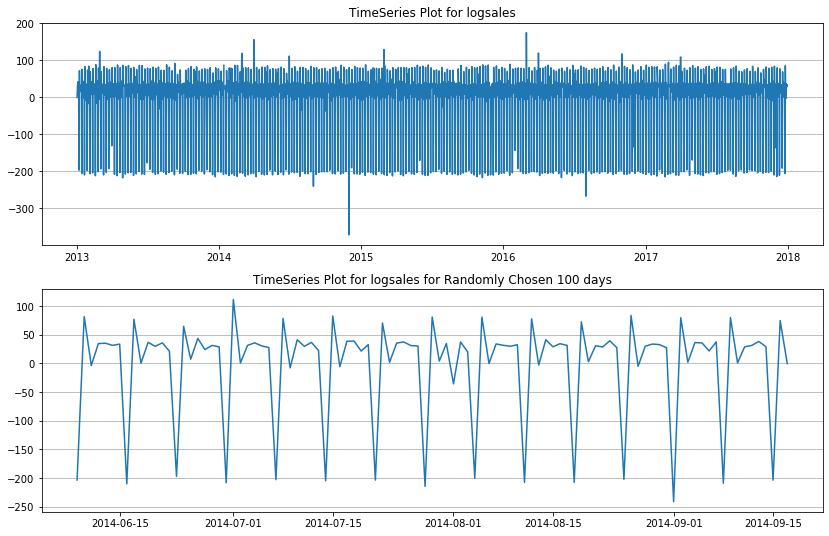

ADF test statistic: -8.9851
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.9638
   5%        -3.4129
  10%        -3.1285

p-value: 3.9215e-13


In [21]:
sales_all_1 = sales_all.diff().dropna()
logsales_all_1 = logsales_all.diff().dropna()

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(logsales_all_1.index, logsales_all_1)
ax1.set_title('TimeSeries Plot for logsales')
ax1.grid(axis = 'y')

ax2.plot(logsales_all_1.index[523:624], logsales_all_1[523:624])
ax2.set_title('TimeSeries Plot for logsales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

result = adfuller(sales_all_1, regression = 'ct')
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

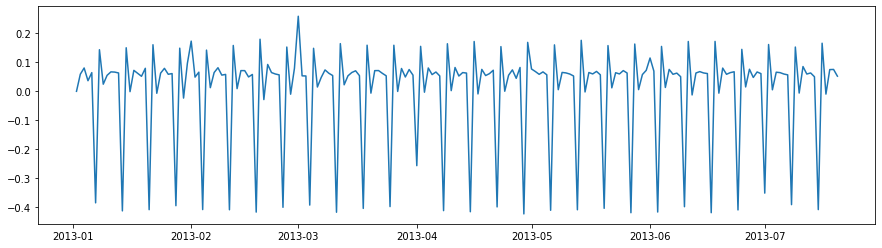

In [170]:
dailysales_all_1 = dailysales_all.diff().dropna()

plt.figure(figsize = (15, 4))
plt.plot(dailysales_all_1.index[:200], dailysales_all_1[:200])
plt.show()

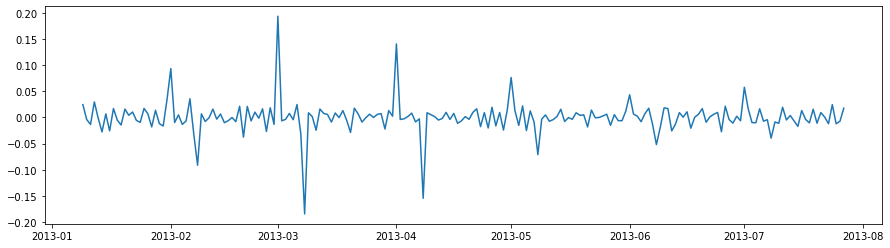

In [169]:
dailysales_all_2 = dailysales_all_1.diff(7).dropna()

plt.figure(figsize = (15, 4))
plt.plot(dailysales_all_2.index[:200], dailysales_all_2[:200])
plt.show()

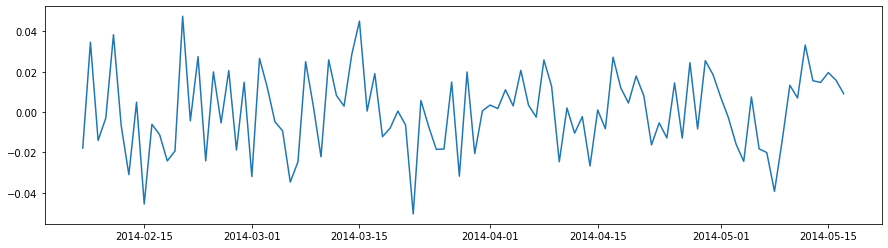

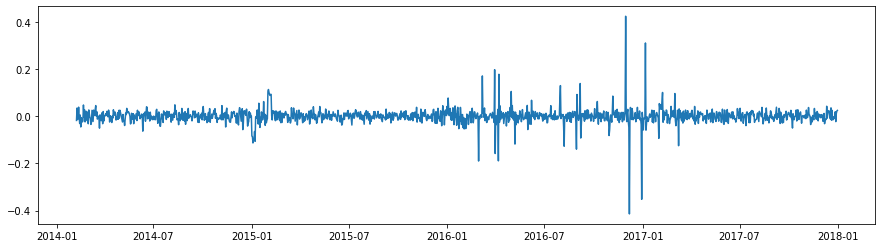

In [161]:
dailysales_all_3 = dailysales_all_2.diff(365).dropna()

plt.figure(figsize = (15, 4))
plt.plot(dailysales_all_3.index[:100], dailysales_all_3[:100])
plt.show()

plt.figure(figsize = (15, 4))
plt.plot(dailysales_all_3.index, dailysales_all_3)
plt.show()

Strategy 4 - Investigating Stationarity

In [171]:
result = adfuller(dailysales_all_2)
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -15.6123
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.4340
   5%        -2.8632
  10%        -2.5676

p-value: 1.7738e-28


Strategy 4 - Investigating Existence of Autocorrelation

In [172]:
result = acorr_ljungbox(dailysales_all_2, lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1     2.889161e-02
2     8.555878e-02
3     1.657278e-01
4     2.720016e-01
5     3.740653e-01
6     3.821554e-01
7     7.235852e-98
8     3.099846e-97
9     2.459807e-96
10    1.335720e-95
Name: lb_pvalue, dtype: float64


Strategy 4 - Investigating ACF and PACF

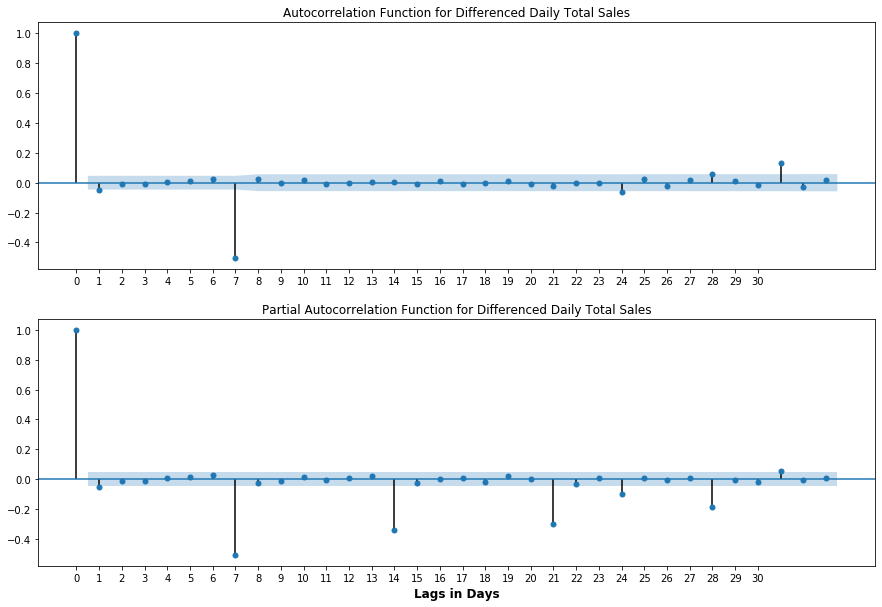

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 10))

tsaplots.plot_acf(dailysales_all_2, ax = ax1, alpha = 0.05,
                  title = 'Autocorrelation Function for Differenced Daily Total Sales')
tsaplots.plot_pacf(dailysales_all_2, ax = ax2, alpha = 0.05,
                   title = 'Partial Autocorrelation Function for Differenced Daily Total Sales')

ax1.set_xticks(np.arange(0, 31, 1))
ax2.set_xticks(np.arange(0, 31, 1))
ax2.set_xlabel('Lags in Days', fontsize = '12', fontweight = 'bold')

plt.show()

### ARMA Model Parameters - Grid Search

The exploratory data analysis helps us set up the following grid for the transformed timeseries:
<ol>
    <li>MA params: p = 0, 1, 2, 3, 4, 5, 6, 7, 8
    <li>AR params: q = 0, 1, 2, 3, 4, 5, 6
</ol>

In [133]:
# Set the parameter grid
ma_params = [0, 1, 6, 7, 8]
ar_params = [0, 1, 2, 3, 4, 5, 6]

# ARMA model pipeline
for p in ma_params:
    for q in ar_params:
        try:
            model = ARMA(dailysales_all_4, order = (p, q)).fit(solver = 'powell')
            print('ARMA{} - AIC:{}'.format((p,q), model.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: -1.658135
         Iterations: 1
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: -1.987265
         Iterations: 2
         Function evaluations: 99
ARMA(0, 1) - AIC:-5649.757359880414
Optimization terminated successfully.
         Current function value: -1.987658
         Iterations: 2
         Function evaluations: 108
ARMA(0, 2) - AIC:-5648.875413256408


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: -1.989451
         Iterations: 2
         Function evaluations: 132
ARMA(0, 3) - AIC:-5651.976145541315


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: -1.989526
         Iterations: 2
         Function evaluations: 150


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(0, 4) - AIC:-5650.19217303356
Optimization terminated successfully.
         Current function value: -2.013104
         Iterations: 2
         Function evaluations: 158
ARMA(0, 5) - AIC:-5715.29372859262
Optimization terminated successfully.
         Current function value: -2.021270
         Iterations: 2
         Function evaluations: 182
ARMA(0, 6) - AIC:-5736.533134617883
Optimization terminated successfully.
         Current function value: -1.814318
         Iterations: 1
         Function evaluations: 27
ARMA(1, 0) - AIC:-5157.549475705255
Optimization terminated successfully.
         Current function value: -1.987709
         Iterations: 2
         Function evaluations: 107
ARMA(1, 1) - AIC:-5649.018556053914
Optimization terminated successfully.
         Current function value: -1.993146
         Iterations: 2
         Function evaluations: 130
ARMA(1, 2) - AIC:-5662.493914959563


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Optimization terminated successfully.
         Current function value: -1.998891
         Iterations: 2
         Function evaluations: 138
ARMA(1, 3) - AIC:-5676.842889203956
Optimization terminated successfully.
         Current function value: -2.000748
         Iterations: 2
         Function evaluations: 158
ARMA(1, 4) - AIC:-5680.1299714781235
Optimization terminated successfully.
         Current function value: -2.048218
         Iterations: 4
         Function evaluations: 372
ARMA(1, 5) - AIC:-5813.228911780077
Optimization terminated successfully.
         Current function value: -2.070481
         Iterations: 2
         Function evaluations: 212


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(1, 6) - AIC:-5874.590244815625
Optimization terminated successfully.
         Current function value: -1.971133
         Iterations: 1
         Function evaluations: 83
ARMA(6, 0) - AIC:-5593.845815405768
Optimization terminated successfully.
         Current function value: -1.991164
         Iterations: 1
         Function evaluations: 96
ARMA(6, 1) - AIC:-5648.853588206644
Optimization terminated successfully.
         Current function value: -2.043118
         Iterations: 2
         Function evaluations: 214
ARMA(6, 2) - AIC:-5794.714766778348


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(6, 3) - AIC:nan
Optimization terminated successfully.
         Current function value: -2.130528
         Iterations: 1
         Function evaluations: 137
ARMA(6, 4) - AIC:-6039.484101862314
Optimization terminated successfully.
         Current function value: -2.179384
         Iterations: 12
         Function evaluations: 1936


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(6, 5) - AIC:-6176.527211863951
Optimization terminated successfully.
         Current function value: -2.172043
         Iterations: 10
         Function evaluations: 1676


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(6, 6) - AIC:-6153.6335452056155
Optimization terminated successfully.
         Current function value: -2.021408
         Iterations: 1
         Function evaluations: 95
ARMA(7, 0) - AIC:-5734.927434442428
Optimization terminated successfully.
         Current function value: -2.104399
         Iterations: 3
         Function evaluations: 352
ARMA(7, 1) - AIC:-5969.119322131826
Optimization terminated successfully.
         Current function value: -2.107378
         Iterations: 2
         Function evaluations: 260
ARMA(7, 2) - AIC:-5975.598943752708
Optimization terminated successfully.
         Current function value: -2.106998
         Iterations: 2
         Function evaluations: 280


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(7, 3) - AIC:-5972.514967030271
Optimization terminated successfully.
         Current function value: -2.132569
         Iterations: 2
         Function evaluations: 294
ARMA(7, 4) - AIC:-6043.291493736313
Optimization terminated successfully.
         Current function value: -2.142712
         Iterations: 8
         Function evaluations: 1266


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(7, 5) - AIC:-6070.159762226629
Optimization terminated successfully.
         Current function value: -2.213974
         Iterations: 6
         Function evaluations: 1051
ARMA(7, 6) - AIC:-6270.9713193859625
Optimization terminated successfully.
         Current function value: -2.050086
         Iterations: 1
         Function evaluations: 108
ARMA(8, 0) - AIC:-5814.5439399739735
Optimization terminated successfully.
         Current function value: -2.108877
         Iterations: 2
         Function evaluations: 279
ARMA(8, 1) - AIC:-5979.86529946136
Optimization terminated successfully.
         Current function value: -2.104448
         Iterations: 2
         Function evaluations: 283


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(8, 2) - AIC:-5965.257697751997
Optimization terminated successfully.
         Current function value: -2.108956
         Iterations: 2
         Function evaluations: 291


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(8, 3) - AIC:-5976.088167009879
Optimization terminated successfully.
         Current function value: -2.131363
         Iterations: 2
         Function evaluations: 311
ARMA(8, 4) - AIC:-6037.859546188469
Optimization terminated successfully.
         Current function value: -2.142983
         Iterations: 6
         Function evaluations: 1009


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARMA(8, 5) - AIC:-6068.928630067885
Optimization terminated successfully.
         Current function value: -2.217086
         Iterations: 9
         Function evaluations: 1683
ARMA(8, 6) - AIC:-6277.826997923357


BEST ARMA Results ARMA(8, 6) - AIC:-6277.826997923357

Build a model using the train subset and see its predictive power on the validation subset

In [144]:
n_train = np.int(0.9*len(dailysales_all_4))
n_val = len(dailysales_all_4) - n_train
display(n_train, n_val, len(dailysales_all_4))

1280

143

1423

In [155]:
model = ARMA(dailysales_all_4[:n_train], (8, 6))
results = model.fit(solver = 'powell')
preds = results.predict(dailysales_all_4.index[n_train], dailysales_all_4.index[-1])

Optimization terminated successfully.
         Current function value: -2.177344
         Iterations: 9
         Function evaluations: 1702


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


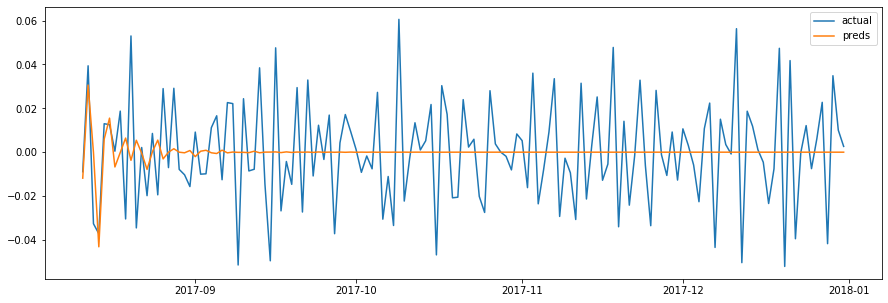

In [156]:
plt.figure(figsize = (15, 5))
plt.plot(dailysales_all_4.index[n_train:], dailysales_all_4[n_train:], label = 'actual')
plt.plot(dailysales_all_4.index[n_train:], preds, label = 'preds')
plt.legend()
plt.show()

In [158]:
mape = np.mean(abs((dailysales_all_4[n_train:]-preds)/dailysales_all_4[n_train:]))*100
smape = np.mean((np.abs(preds - dailysales_all_4[n_train:]) * 200/ (np.abs(preds) + np.abs(dailysales_all_4[n_train:]))).fillna(0))
print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

MAPE: 108.69 % 
SMAPE: 192.29 %
